### NLP-based approach to review score prediction
##### Zuzanna Liberto

<br> The dataset used in this project was downloaded from Kaggle <br> https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe <br> <br> It contains 515,000 customer reviews and scoring of 1493 luxury hotels across Europe.

In [342]:
# data manipulation
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import wordcloud
# text manipulation
import re
import string
import random
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
# machine learning and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# misc
import time

### 1. Data Prep and EDA

In [2]:
# import the dataset
data = pd.read_csv("Hotel_Reviews.csv") 

# store hotel coordinates separately
cords = data[["Hotel_Name","lat", "lng"]].drop_duplicates()

# select only relevant columns
data = data[["Hotel_Name", "Average_Score", "Reviewer_Nationality", "Reviewer_Score", "Negative_Review", "Review_Total_Negative_Word_Counts", "Positive_Review", "Review_Total_Positive_Word_Counts"]]
data.head(5)


,Hotel_Name,Average_Score,Reviewer_Nationality,Reviewer_Score,Negative_Review,Review_Total_Negative_Word_Counts,Positive_Review,Review_Total_Positive_Word_Counts
0,Hotel Arena,7.7,Russia,2.9,I am so angry that i made this post available...,397,Only the park outside of the hotel was beauti...,11
1,Hotel Arena,7.7,Ireland,7.5,No Negative,0,No real complaints the hotel was great great ...,105
2,Hotel Arena,7.7,Australia,7.1,Rooms are nice but for elderly a bit difficul...,42,Location was good and staff were ok It is cut...,21
3,Hotel Arena,7.7,United Kingdom,3.8,My room was dirty and I was afraid to walk ba...,210,Great location in nice surroundings the bar a...,26
4,Hotel Arena,7.7,New Zealand,6.7,You When I booked with your company on line y...,140,Amazing location and building Romantic setting,8


In [3]:
print("This dataframe has", data.shape[0], "rows and", data.shape[1], "columns")

This dataframe has 515738 rows and 8 columns


In [4]:
# replace No Negative and No Positive values with an empty space
data = data.replace("No Negative", "")
data = data.replace("No Positive", "")

In [5]:
# total amount of NaNs in the dataframe = 0
data.isnull().sum()

Hotel_Name                           0
Average_Score                        0
Reviewer_Nationality                 0
Reviewer_Score                       0
Negative_Review                      0
Review_Total_Negative_Word_Counts    0
Positive_Review                      0
Review_Total_Positive_Word_Counts    0
dtype: int64

In [7]:
print("There are", data["Hotel_Name"].nunique(), "unique hotels in this dataset")

There are 1492 unique hotels in this dataset


### EDA

1. Distribution of Reviewer Scores

Text(0.5, 1.0, 'Distribution of Reviewer Scores')

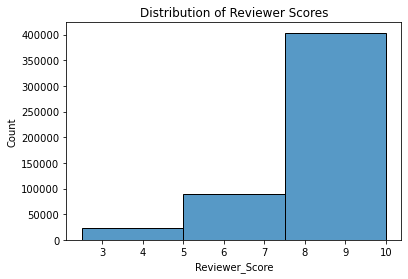

In [92]:
# check the distribution of reviewer scores
sns.histplot(data = data, x = "Reviewer_Score", bins = 3).set_title("Distribution of Reviewer Scores")

It looks like most reviews range from 7 to 10, so are mostly positive. 

In [9]:
print("More characteristics:\n- mean:", round(data["Reviewer_Score"].mean(),2), "\n- median:", round(data["Reviewer_Score"].median(), 2))

More characteristics:
- mean: 8.4 
- median: 8.8


<br>2. Distribution of Hotel Scores

Text(0.5, 1.0, 'Distribution of Hotel Scores')

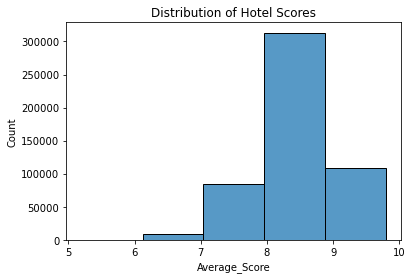

In [89]:
# check distributon of hotel scores
sns.histplot(data = data, x = "Average_Score", bins = 5).set_title("Distribution of Hotel Scores")

Most hotels are in the 8-9 score range.

<br>3. Distribution of thr reviewers' nationalities.

[]

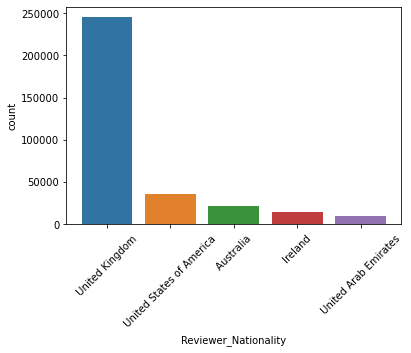

In [94]:
cp = sns.countplot(x = "Reviewer_Nationality", data = data, order=pd.value_counts(data['Reviewer_Nationality']).iloc[:5].index)
cp.set_xticklabels(cp.get_xticklabels(),rotation=45)
cp.plot()

Most reviewers are from the United Kigdom.

<br>4. Distribution of review word counts.

In [12]:
tmp = data[["Review_Total_Negative_Word_Counts", "Review_Total_Positive_Word_Counts"]]
tmp.columns = ["Negative", "Positive"]
tmp = pd.melt(tmp)
tmp.columns = ["Negative vs Positive","Word Count"]

Text(0.5, 1.0, 'Distribution of review word counts')

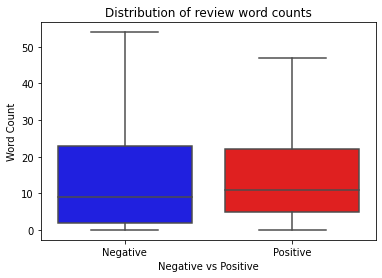

In [95]:
sns.boxplot(data = tmp, x = "Negative vs Positive", y = "Word Count", fliersize = 0.2 , palette = ["b", "r"], showfliers = False).set_title("Distribution of review word counts")

It looks like negative reviews tend to be slightly longer than the positive reviews.

<br>4. Distribution of hotel locations.

In [14]:
cords = cords.dropna()
#there's 17 NaNs in the coordnates so we want to drop these rows
cords.isnull().sum()

Hotel_Name    0
lat           0
lng           0
dtype: int64

In [19]:
# get the average latitute and longitude to center the map
avg_lat = cords["lat"].mean()
avg_lng = cords["lng"].mean()

In [25]:
# prepare the coordinates
cords = cords[["lat", "lng"]]
cords1 = cords.groupby(["lat", "lng"]).sum().reset_index().values.tolist()

In [343]:
base_map = folium.Map(location=[avg_lat, avg_lng], control_scale=True, zoom_start=5)
HeatMap(data=cords1, radius=40, blur = 30, max_zoom=13).add_to(base_map)
base_map

It looks like most hotels are in the United Kingdom and France.

### 2. Textual data analysis

1. Preprocess the textual data 

I had to take a sample of the original data (10%) because it was taking so long to process. 

In [142]:
txt_data = data[["Positive_Review", "Negative_Review", "Reviewer_Score"]]
txt_data_sample = txt_data.sample(frac = 0.1, axis = 0)

This function returns a Part-of-Speech tag. It's a common function used for POS tagging with the NLTK wordnet.

In [106]:
def get_pos(word):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

This function removes the stopwords from the reviews, converts each review to lowercase, removes all numbers, and lemmatizes each word. It returns a clean review.

In [107]:
# prepare my own stopwords excluding no and not
new_stopwords = set(stopwords.words('english')) - {'no', 'not'}
# regex pattern to remove the stopwords
pattern = re.compile(r'\b(' + r'|'.join(new_stopwords) + r')\b\s*')

def preprocessReviews(row):
    # to lowercase
    tmp = row.lower()
    # remove the stopwords
    tmp = pattern.sub('', tmp)
    # remove numbers
    tmp = re.sub("\d+", "", tmp)
    # tokenize the review
    splt = tmp.split(" ")
    # remove empty tokens from the list
    splt = [t for t in splt if len(t) > 0]
    # use a POS tagger to get a tagged token
    pos = pos_tag(splt)
    # lemmatize each word
    lem = [WordNetLemmatizer().lemmatize(w[0], get_pos(w[1])) for w in pos] 
    # put it all together
    text = " ".join(lem)
    return text

In [183]:
# apply the function to preprocess all reviews
start_time = time.time()
txt_data_sample["Positive_Review"] = txt_data_sample["Positive_Review"].apply(preprocessReviews)
txt_data_sample["Negative_Review"] = txt_data_sample["Negative_Review"].apply(preprocessReviews)
print((time.time() - start_time)/60, "minutes")

1.4012146631876627 minutes


In [184]:
txt_data_sample.head(5)

,Positive_Review,Negative_Review,Reviewer_Score
403963,location great city center vienna,bed short person cm single room,7.5
157510,staff extremely nice helpful,,10.0
107772,comfortable clean,shower not properly seal water spill bathroom ...,9.2
279885,appreciate warm welcome help receive soon ente...,window could cleaner could get good picture fi...,9.6
492898,room really comfortable bed amaze minute walk ...,,10.0


2. Topic Modeling

<b> Positive topics:

In [275]:
pos_rev_data = txt_data_sample.loc[txt_data_sample["Reviewer_Score"] >= 8, "Positive_Review"]
count_vect_pos = CountVectorizer(max_df=0.85, min_df=4, stop_words = 'english')
doc_term_matrix_pos = count_vect_pos.fit_transform(pos_rev_data.values.astype('U'))

In [327]:
LDA_pos = LatentDirichletAllocation(n_components=4, doc_topic_prior = 0.05, topic_word_prior = 0.01)
LDA_pos.fit(doc_term_matrix_pos)

LatentDirichletAllocation(doc_topic_prior=0.05, n_components=4,
                          topic_word_prior=0.01)

In [341]:
for i,topic in enumerate(LDA_pos.components_):
    print(f'Top 10 positive words for topic #{i+1}:')
    print([count_vect_pos.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 positive words for topic #1:
['hotel', 'clean', 'breakfast', 'excellent', 'friendly', 'good', 'room', 'great', 'staff', 'location']


Top 10 positive words for topic #2:
['metro', 'stay', 'great', 'restaurant', 'minute', 'close', 'station', 'location', 'walk', 'hotel']


Top 10 positive words for topic #3:
['location', 'great', 'excellent', 'breakfast', 'room', 'stay', 'friendly', 'helpful', 'hotel', 'staff']


Top 10 positive words for topic #4:
['bathroom', 'lovely', 'hotel', 'view', 'great', 'nice', 'comfy', 'comfortable', 'bed', 'room']




<b> Negative topics:

In [337]:
neg_rev_data = txt_data_sample.loc[txt_data_sample["Reviewer_Score"] <=5, "Negative_Review"]
count_vect_neg = CountVectorizer(max_df=0.9, min_df=1, stop_words = 'english')
doc_term_matrix_neg = count_vect_neg.fit_transform(neg_rev_data.values.astype('U'))

In [338]:
LDA_neg = LatentDirichletAllocation(n_components=4, doc_topic_prior = 0.05, topic_word_prior = 0.01)
LDA_neg.fit(doc_term_matrix_neg)

LatentDirichletAllocation(doc_topic_prior=0.05, n_components=4,
                          topic_word_prior=0.01)

In [340]:
for i,topic in enumerate(LDA_neg.components_):
    print(f'Top 10 negative words for topic #{i+1}:')
    print([count_vect_neg.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 negative words for topic #1:
['clean', 'bathroom', 'need', 'bed', 'check', 'old', 'small', 'staff', 'hotel', 'room']


Top 10 negative words for topic #2:
['food', 'star', 'bed', 'water', 'poor', 'breakfast', 'service', 'hotel', 'room', 'staff']


Top 10 negative words for topic #3:
['ask', 'like', 'book', 'staff', 'night', 'small', 'stay', 'bed', 'hotel', 'room']


Top 10 negative words for topic #4:
['price', 'poor', 'money', 'work', 'bad', 'service', 'pay', 'breakfast', 'hotel', 'room']




3. Tokenize the reviews

I tokenize both positive and negative review columns to get more insights on what words appear in the most positive scores and most negative scores.

In [32]:
txt_data_tokens = txt_data_sample.copy()

In [33]:
# tokenize the columns
start_time = time.time()
txt_data_tokens["Pos_Tokens"] = txt_data_tokens["Positive_Review"].apply(nltk.word_tokenize)
txt_data_tokens["Neg_Tokens"] = txt_data_tokens["Negative_Review"].apply(nltk.word_tokenize)
print(time.time() - start_time, "seconds")

12.004304885864258 seconds


In [34]:
txt_data_tokens = txt_data_tokens[["Reviewer_Score","Pos_Tokens", "Neg_Tokens"]]
txt_data_tokens.head(5)

,Reviewer_Score,Pos_Tokens,Neg_Tokens
374140,10.0,"[bed, amaze, great, rest, room, look, beautifu...","[room, service, bar, close, night, give, two, ..."
224275,9.6,"[great, room, view, shard, st, paul, lovely, s...","[aircon, could, clean]"
325539,5.8,"[overall, nice, hotel, good, location]","[book, non, smoking, room, obviously, previous..."
154270,7.1,"[good, location, comfortable, room]",[]
263233,7.5,[location],[]


I subset this dataframe to get only the most positive and most negative reviews.

In [40]:
pos_tokens_pos_rev = txt_data_tokens.loc[txt_data_tokens["Reviewer_Score"] >= 8, "Pos_Tokens"]
neg_tokens_neg_rev = txt_data_tokens.loc[txt_data_tokens["Reviewer_Score"] <=5, "Neg_Tokens"]

Now, I get the frequency distribution for each token and keep the most common 50 for both positive and negative reviews.

In [41]:
fdist_pos_tokens_pos_rev = nltk.FreqDist()

for i in range(0, len(pos_tokens_pos_rev)):
    for token in pos_tokens_pos_rev.iloc[i]:
        fdist_pos_tokens_pos_rev[token] += 1
        
pos_cols = dict(fdist_pos_tokens_pos_rev.most_common(50))
pos_cols

{'staff': 15523,
 'room': 13795,
 'location': 12626,
 'hotel': 10259,
 'great': 8620,
 'good': 7143,
 'friendly': 6776,
 'breakfast': 6338,
 'helpful': 6048,
 'excellent': 5162,
 'clean': 4992,
 'nice': 4939,
 'bed': 4780,
 'comfortable': 4736,
 'stay': 3698,
 'lovely': 3020,
 'walk': 2484,
 'everything': 2465,
 'really': 2342,
 'service': 2321,
 'station': 2293,
 'perfect': 2189,
 'close': 2137,
 'well': 2081,
 'restaurant': 2004,
 'bar': 1819,
 'view': 1773,
 'quiet': 1727,
 'u': 1606,
 'would': 1606,
 'comfy': 1561,
 'not': 1549,
 'love': 1448,
 'also': 1440,
 'bathroom': 1423,
 'fantastic': 1383,
 'facility': 1352,
 'food': 1349,
 'modern': 1341,
 'area': 1336,
 'get': 1314,
 'spacious': 1280,
 'london': 1279,
 'make': 1257,
 'free': 1252,
 'amaze': 1240,
 'beautiful': 1232,
 'like': 1232,
 'place': 1182,
 'metro': 1174}

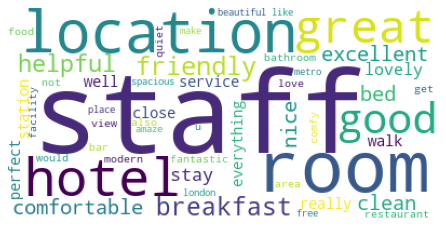

In [59]:
wc = wordcloud.WordCloud(background_color = "white")
wc.fit_words(pos_cols)
plt.figure(facecolor='w')
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad=0)

In [60]:
fdist_neg_tokens_neg_rev = nltk.FreqDist()

for i in range(0, len(neg_tokens_neg_rev)):
    for token in neg_tokens_neg_rev.iloc[i]:
        fdist_neg_tokens_neg_rev[token] += 1
        
neg_cols = dict(fdist_neg_tokens_neg_rev.most_common(50))
neg_cols

{'room': 3323,
 'not': 2180,
 'hotel': 1541,
 'no': 1111,
 'staff': 809,
 'small': 651,
 'bed': 600,
 'breakfast': 529,
 'get': 489,
 'night': 473,
 'stay': 469,
 'one': 457,
 'book': 441,
 'bathroom': 411,
 'service': 394,
 'work': 385,
 'even': 377,
 'poor': 374,
 'bad': 371,
 'pay': 357,
 'day': 342,
 'would': 340,
 'star': 334,
 'u': 334,
 'check': 332,
 'ask': 329,
 'time': 318,
 'reception': 314,
 'like': 310,
 'shower': 300,
 'clean': 296,
 'could': 289,
 'dirty': 274,
 'go': 273,
 'give': 273,
 'old': 270,
 'make': 270,
 'need': 252,
 'floor': 250,
 'tell': 248,
 'also': 243,
 'water': 241,
 'take': 235,
 'say': 233,
 'good': 230,
 'money': 222,
 'window': 217,
 'air': 217,
 'come': 216,
 'door': 214}

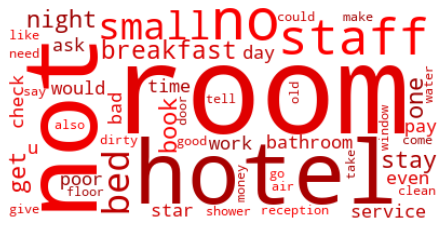

In [345]:
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 100%%, %d%%)" % random.randint(30, 50)

wc = wordcloud.WordCloud(background_color = "white")
wc.fit_words(neg_cols)
plt.figure(facecolor='w')
plt.imshow(wc.recolor(color_func=red_color_func),interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)


Now, I want to add these most common tokens as variables. Each key in the most common negative tokens and most common positive tokens dictionary will become it's own variable. They'll take a value of True if the token is found in each review, and False if it's not.

In [62]:
# this function loops over a list of tokens (each row, so over each tokenized review)

def loopOverTokens(toklist, word):
    if word in toklist:
        return int(True)
    else:
        return int(False)

In [63]:
# this function will return the results which will become a variable

def getVals(word, colname):
    col = txt_data_tokens[colname].apply(lambda passedlist: loopOverTokens(passedlist, word))
    return col

In [64]:
# convert the dictionary to a dataframe and drop the first row (values of the dictionary)
pos_temp = pd.DataFrame([pos_cols]).drop(0, axis = 0)

In [65]:
# apply the function to get the values (whether the word was found in a each row of positive review tokens)
pos_wordfound = pos_temp.columns.to_series().apply(lambda name: getVals(name, "Pos_Tokens"))
pos_wordfound = pos_wordfound.transpose()

In [66]:
# convert the dictionary to a dataframe and drop the first row (values of the dictionary)
neg_temp = pd.DataFrame([neg_cols]).drop(0, axis = 0)

In [67]:
# apply the function to get the values (whether the word was found in a each row of negative review tokens)
neg_wordfound = neg_temp.columns.to_series().apply(lambda name: getVals(name, "Neg_Tokens"))
neg_wordfound = neg_wordfound.transpose()

In [68]:
# there will be duplicate column names, so append each column name with a suffix
pos_wordfound.columns = [str(col) + '_pos' for col in pos_wordfound.columns]
neg_wordfound.columns = [str(col) + '_neg' for col in neg_wordfound.columns]

In [69]:
# join the dataframes together
cols_to_add = pd.concat([pos_wordfound, neg_wordfound], axis=1)
cols_to_add.head(5)

,staff_pos,room_pos,location_pos,hotel_pos,great_pos,good_pos,friendly_pos,breakfast_pos,helpful_pos,excellent_pos,...,also_neg,water_neg,take_neg,say_neg,good_neg,money_neg,window_neg,air_neg,come_neg,door_neg
374140,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
224275,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
325539,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154270,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263233,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3. Predicting the reviewer score column

1. Prepare the dataframe for modeling

In [70]:
# take the same subset of data from the full dataframe
data2 = data[data.index.isin(cols_to_add.index)]
# keep the columns that will be used for modeling
data2 = data2[["Reviewer_Score", "Review_Total_Positive_Word_Counts", "Review_Total_Negative_Word_Counts", "Reviewer_Nationality"]]
# convert the reviewer's nationality column to categorical
data2["Reviewer_Nationality"] = pd.Categorical(data2["Reviewer_Nationality"])
# check the datatypes of each variable
data2.dtypes

Reviewer_Score                        float64
Review_Total_Positive_Word_Counts       int64
Review_Total_Negative_Word_Counts       int64
Reviewer_Nationality                 category
dtype: object

In [71]:
data2["Reviewer_Score"] = np.asarray(data2["Reviewer_Score"], dtype = np.float64)

In [72]:
# convert the reviewer nationality column to numerical (dummy)
data2["Reviewer_Nationality"] = data2["Reviewer_Nationality"].cat.codes

In [73]:
data2.dtypes

Reviewer_Score                       float64
Review_Total_Positive_Word_Counts      int64
Review_Total_Negative_Word_Counts      int64
Reviewer_Nationality                   int16
dtype: object

In [74]:
# now, merge the initial dataframe with the variables based on the occurence of each word in a review
data_merged = data2.join(cols_to_add)
data_merged.head(5)

,Reviewer_Score,Review_Total_Positive_Word_Counts,Review_Total_Negative_Word_Counts,Reviewer_Nationality,staff_pos,room_pos,location_pos,hotel_pos,great_pos,good_pos,...,also_neg,water_neg,take_neg,say_neg,good_neg,money_neg,window_neg,air_neg,come_neg,door_neg
0,2.9,11,397,133,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,7.5,105,0,76,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5,6.7,20,17,128,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
13,9.2,59,0,79,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
30,9.2,28,7,76,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
# Get x and y values
x = data_merged.iloc[:,1:]
y = data_merged.iloc[:,0]

Check the correlation of top 15 negative and positive variables

In [240]:
corr = data_merged.corr().iloc[:,1]
neg_cor = corr.sort_values().iloc[0:14]
pos_cor = corr.sort_values(ascending = False).iloc[0:14]
df = pd.concat([pos_cor, neg_cor],ignore_index=False)

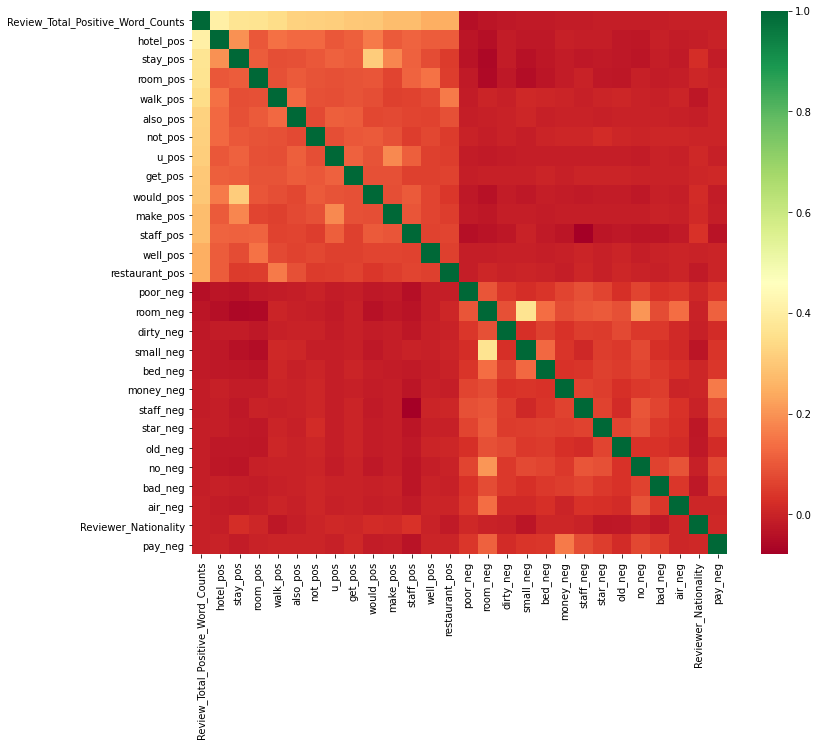

In [241]:
top_corr_features = df.index
plt.figure(figsize=(12,10))
#plot heat map
g=sns.heatmap(data_merged[top_corr_features].corr(),annot= False,cmap="RdYlGn")

In [76]:
# get the train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30)

2. Train and fine tune the XGBoost model 

In [77]:
# get DMatrix structures for test and train sets
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(x_test, label = y_test)

In [78]:
# set the booster parameters
params = {
 #I'll track Mean Absolute Error as the evaluation metric
 'eval_metric': 'mae',
 'max_depth': 9,
 'min_child_weight': 6,
 'subsample': 0.9,
 'colsample_bytree': 0.7,
 'eta': 0.01,
 # squared loss regression as the objective funtion
 'objective': 'reg:squarederror'}

In [79]:
# train the model
model = xgb.train(params, dtrain, num_boost_round=1050, evals=[(dtest, "Test")], early_stopping_rounds=10, verbose_eval = False)

In [80]:
print("Best MAE during the model training:", model.best_score, "with", model.best_iteration+1, "iterations")

Best MAE during the model training: 0.863796 with 1050 iterations


Now, I'll perform a 5-fold cross-validation.

In [81]:
# I'll track MAE again during the CV
cv_results = xgb.cv(params, dtrain, num_boost_round=1050, nfold=5, metrics={"mae", "rmse"}, early_stopping_rounds=10)
cv_results

,train-mae-mean,train-mae-std,train-rmse-mean,train-rmse-std,test-mae-mean,test-mae-std,test-rmse-mean,test-rmse-std
0,7.800334,0.003036,7.969931,0.002737,7.800261,0.012264,7.969934,0.011027
1,7.722423,0.002994,7.892558,0.002727,7.722395,0.012299,7.892597,0.010985
2,7.645349,0.002962,7.815854,0.002726,7.645322,0.012263,7.815942,0.010943
3,7.569023,0.002917,7.739960,0.002728,7.568970,0.012257,7.740069,0.010865
4,7.493432,0.002950,7.664882,0.002641,7.493415,0.012229,7.665044,0.010909
...,...,...,...,...,...,...,...,...
1045,0.724781,0.002520,0.988654,0.002189,0.869980,0.008108,1.167186,0.008068
1046,0.724701,0.002517,0.988573,0.002184,0.869979,0.008109,1.167185,0.008066
1047,0.724589,0.002514,0.988447,0.002176,0.869970,0.008109,1.167170,0.008069
1048,0.724485,0.002496,0.988332,0.002162,0.869962,0.008118,1.167164,0.008084


In [82]:
cv_results['test-mae-mean'].min()

0.8699600000000001

In [83]:
cv_results['test-rmse-mean'].min()

1.1671558000000002

3. Apply the model to predict on the test data and evaluate the model

In [84]:
pred = model.predict(dtest)

In [189]:
rmse = np.sqrt(MSE(y_test, pred)) 
mae = mean_absolute_error(y_test, pred)
error = pred - y_test
error = abs(error)
error_rate = np.mean(error)/np.mean(y_test)
print("RMSE of this model:", round(rmse,3), "\nMAE of this model:", round(mae,3), "\nError rate of this model:", round(error_rate, 2)*100, "%")

RMSE of this model: 1.155 
MAE of this model: 0.864 
Error rate of this model: 10.0 %


<b>The model has a RMSE of 1.155, MAE of 0.86 and an error rate of 10.2%

Sample predictions

In [87]:
y_df = pd.DataFrame(y_test)
y_df["Predicted_Score"] = pred
y_df.head(10)

,Reviewer_Score,Predicted_Score
470415,8.3,9.219895
506606,9.6,9.426361
32057,10.0,9.139439
447590,10.0,9.695793
26456,10.0,8.581619
210000,8.8,9.315465
307360,8.8,8.968274
410833,9.2,9.577826
12974,9.2,8.534766
223462,7.1,8.190145


Text(0, 0.5, 'Frequency')

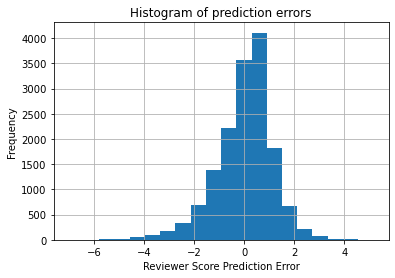

In [88]:
# get residuals
res = y_df["Reviewer_Score"] - y_df["Predicted_Score"]
res.hist(bins = 20)
plt.title('Histogram of prediction errors')
plt.xlabel('Reviewer Score Prediction Error')
plt.ylabel('Frequency')